In [5]:
from IPython import get_ipython
ipython = get_ipython()
if '__IPYTHON__' in globals():
    ipython.magic('load_ext autoreload')
    ipython.magic('autoreload 2')

import argparse
import os
from glob import glob
import pickle

import numpy as np
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt

import tensorflow as tf
# import tensorflow_probability as tfp
import tensorflow_datasets as tfds

from mymodels.four_analyte_model_bounded import (conv, ds_to_array,get_multiple_data,
                                                get_multiple_data_v2, make_bijector,
                                                predict, print_metric, rmse,
                                                predict_non_prob, merge_datasets, make_preprocess, 
                                                shifted_zscore, conv_drop_last, tf_pmse, natural_keys)

def plot_concentrations(y):
    fig, axs = plt.subplots(2, 2, sharey=False, tight_layout=True)
    for ip in range(0,4):
        axs[np.unravel_index(ip, axs.shape)].hist(y[:,ip])


In [7]:
speed = 'slow'

bi_type = 5

# drop_prob = .8
drop_prob = .5
# drop_prob = .1 # default
# drop_prob = 0. # disable

optimizer = 'Adadelta'
learning_rate = 0.85

# optimizer = 'Adam'
# # learning_rate = 0.000001
# # learning_rate = 0.00001
# # learning_rate = 0.00005
# # learning_rate = 0.0001
# learning_rate = 0.0005
# # learning_rate = 0.001
# # beta_1 = 0.9
# beta_1 = 0.1
# # beta_2 = 0.999
# beta_2 = 0.95

tfk = tf.keras
tfkl = tf.keras.layers
tfkr = tf.keras.regularizers
# tfpl = tfp.layers
# tfb = tfp.bijectors
dtype = tf.float32
tf.keras.backend.set_floatx('float32')
npdt = np.float32
names = ['DA', '5HT', 'pH', 'NE']
prefix = os.path.join('/mnt/nfs/proj/in-vitro/Mark/four_analyte/', speed,
                      'allin')
probes = [x.split('/')[-1] for x in glob(prefix + '/CF*')]
probes.sort()
print(probes)

mirrored_strategy = tf.distribute.MirroredStrategy()

good_probes = [
    'CF025', 'CF027', 'CF057', 'CF064', 'CF066', 'CF078', 'CF081', 'CF082'
]
# Only use good data
probes = good_probes  # probes.pop(probes.index(good_probes[args.probe]))
hold_probe = probes.pop(5)
print('hold probe :', hold_probe)

# val_probe=None
val_probe=probes.pop(0)
print('validation probe :', val_probe)

print(f'Training model on probes {probes}.')
print(f'Loading {speed} data')


['CF017', 'CF025', 'CF027', 'CF045', 'CF056', 'CF057', 'CF058', 'CF059', 'CF060', 'CF062', 'CF064', 'CF065', 'CF066', 'CF067', 'CF068', 'CF069', 'CF070', 'CF071', 'CF072', 'CF073', 'CF074', 'CF078', 'CF081', 'CF082']
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
hold probe : CF078
validation probe : CF025
Training model on probes ['CF027', 'CF057', 'CF064', 'CF066', 'CF081', 'CF082'].
Loading slow data


In [8]:
# batch_size = 16384
batch_size = 18495 # about 20 mini-batches
base_depth = 20
# base_depth = 15
kernel_size = 5
force_reload = True
epochs = 500

In [9]:
# train_data, val_data, hold_data = get_multiple_data(prefix,
#                                                     probes,
#                                                     hold_probe,
#                                                     batch_size=batch_size,
#                                                     weight=True,
#                                                     allin=True,
#                                                     bi_type=bi_type)
train_data, val_data, hold_data = get_multiple_data_v2(prefix,
                                                    probes,
                                                    hold_probe,
                                                    val_probe,
                                                    batch_size=batch_size,
                                                    weight=True,
                                                    allin=True,
                                                    bi_type=bi_type)
print('Data loaded')


using CF025 probe for validation and merging TFRecords original validation data into training
Data loaded


In [10]:
tf.__version__

'2.2.0'

In [11]:
# ds = tf.data.TFRecordDataset(train_data[0])
# ds = tf.map()
# mr = 5
# for (i,r) in enumerate(ds):
#     x = r.numpy()
# #     print(x.__class__)
#     v, l = preprocess(r)
#     if i > mr:
#         break

In [12]:

# def shifted_zscore(x, inverse=False):
#     # without zeros shifted by 10 std to avoid negative values
#     mean = [-10410.677490234375, -10414.565185546875, 6.00097793340683, -10413.194091796875]
#     std = [1266.3062, 1266.7249, 0.13912384, 1266.6195]

#     if inverse:
#         x = (x*std)+mean
#     else:
#         x = (x-mean)/std
    
#     return x

# def preprocess(serialized_example):
#     features = tf.io.parse_example(
#         serialized_example,
#         features={
#             'gram': tf.io.FixedLenFeature([], tf.string),
#             'label': tf.io.FixedLenFeature([], tf.string)
#         })
#     data = tf.io.decode_raw(features['gram'], tf.float32)
#     label = tf.io.decode_raw(features['label'], tf.float32)
#     data.set_shape((None, 999))
#     label.set_shape((None, 4))
#     return data, label

# def merge_datasets(vfiles, batch_size, prep, asnumpy=False):
#     yv = []
#     yl = []
#     for filename in vfiles:
#         ds = tf.data.TFRecordDataset(filename)
#         ds = ds.batch(batch_size=batch_size)
#         ds = ds.map(map_func=preprocess)
#         for v,l in ds:
#             v = np.array(v).astype(npdt)
#             l = np.array(l).astype(npdt)
#             yv.append(v)
#             l = np.apply_along_axis(shifted_zscore, axis=1, arr=l) 
#             yl.append(l)
        
#     x = np.vstack(yv)
#     y = np.vstack(yl)

#     if asnumpy:
#         return x,y
#     else:
#         d = tf.data.Dataset.from_tensor_slices((x, y))
#         return d


In [13]:
# # train_data_b = merge_datasets(train_data, batch_size, prep)
# # train_data_b = merge_datasets(train_data, batch_size, shifted_zscore)
# train_data = merge_datasets(train_data, batch_size, shifted_zscore)
# train_data = train_data.shuffle(buffer_size=100_000)
# train_data = train_data.batch(batch_size)
# train_data = train_data.prefetch(tf.data.experimental.AUTOTUNE)
# #     val_data = merge_datasets(val_list, batch_size, prep)
# #     if not allin:
# #         test_data = test_list(train_data, batch_size, prep)
# #     hold_data = merge_datasets(hold_list, batch_size, prep)

In [14]:
# fig, axs = plt.subplots(2, 2, sharey=False, sharex=False, tight_layout=True)
# fig.set_size_inches(10,10)

# # dist = norm
# zeros = shifted_zscore(np.zeros(4))
# for ic in range(0,4):
#     idx = np.unravel_index(ic, axs.shape)
#     x = train_y[:,ic]
#     x = np.array([y for y in x if y > zeros[ic]])
#     print(np.mean(x), np.std(x), np.min(x), np.max(x))
#     axs[idx].hist(x)

In [15]:
input_shape = 999
output_shape = 4
with mirrored_strategy.scope():

    dense_depth=int(64/(1-drop_prob))
    print(f'Dense depth: {dense_depth}', flush=True)
#     dense_depth=int(64/.2)
#     print(f'Fixed Dense depth: {dense_depth}', flush=True)
    
#     vae = conv(input_dim=input_shape,# 999
    vae = conv_drop_last(input_dim=input_shape,# 999
                    encoded_size=output_shape,# 4
                    base_depth=base_depth, # 15
                    kernel_size=kernel_size, # 5
                    norm=True, # true
                    interpool=False, # False
                    dense_depth=dense_depth,
                    drop_prob=drop_prob)

    checkpoint = (
        f'four_analyte/checkpoints/{speed}'
        f'/conv_holdout_allin'
        f'_manual_{hold_probe}_{len(probes)}_{base_depth}_{kernel_size}_{bi_type}_{optimizer}.h5')

    if not force_reload:
        try:
            vae.load_weights(checkpoint)
            print('Found previous model weights.')
        except (OSError, ValueError):
            print('Did not find usable previous model weights.')

    print(f'optimizer {optimizer}', flush=True)
    print(f'learning rate {learning_rate}', flush=True)
    if optimizer == 'Adam':
        print(f'beta_1 {beta_1}, beta_2 {beta_2}', flush=True)
        opt = tfk.optimizers.Adam(learning_rate=learning_rate, beta_2=beta_2, beta_1=beta_1)
#         lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#             learning_rate,
#             decay_steps=100000,
#             decay_rate=0.96,
#             staircase=True)
#         opt = tfk.optimizers.Adam(learning_rate=lr_schedule, beta_2=0.99)
    elif optimizer == 'RMSprop':
        opt = tfk.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'Adadelta':
        opt = tfk.optimizers.Adadelta(learning_rate=learning_rate,
                                  epsilon=tfk.backend.epsilon())
    else:
        raise ValueError("Unknown optimizer %s"%optimizer)

    vae.compile(optimizer=opt,
                loss='mse',
#                 loss=tf_pmse,
                metrics=[tf_pmse, tfk.metrics.RootMeanSquaredError(),], # ,'mse'
                experimental_run_tf_function=False)
    model_file = (
        f'four_analyte/models/{speed}'
        f'/conv_holdout_allin'
        f'_manual_{hold_probe}_{len(probes)}_{base_depth}_{kernel_size}_{bi_type}_{optimizer}.h5')

    tfk.models.save_model(vae, model_file)

cb = [
    tfk.callbacks.ModelCheckpoint(
        checkpoint,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='auto',
        save_freq='epoch',
    ),
    tfk.callbacks.TerminateOnNaN(),
    tf.keras.callbacks.TensorBoard(
        log_dir=os.path.join('four_analyte', 'checkpoints', speed, 'logs',
                             'holdout', 'allin', hold_probe),
        histogram_freq=1,
        write_graph=False,
        write_images=True,
        update_freq='epoch',
        # profile_batch="20, 25",
        embeddings_freq=0,
        embeddings_metadata=None),
    # tfk.callbacks.ReduceLROnPlateau(monitor='val_loss',
    #                                 factor=0.8,
    #                                 patience=10,
    #                                 verbose=1,
    #                                 mode='min',
    #                                 min_delta=0.0001,
    #                                 cooldown=0,
    #                                 min_lr=0.05)
]



Dense depth: 128
Dropout disabled for layer 0
Dropout disabled for layer 1
Dropout disabled for layer 2
Dropout disabled for layer 3
Dropout disabled for layer 4
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',)

In [16]:
vae.summary()
# tfk.utils.plot_model(vae, show_shapes=True)

Model: "conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 999)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 999, 1)            0         
_________________________________________________________________
conv_0 (Conv1D)              (None, 995, 20)           120       
_________________________________________________________________
conv_norm_0 (SyncBatchNormal (None, 995, 20)           80        
_________________________________________________________________
conv_1 (Conv1D)              (None, 986, 20)           4020      
_________________________________________________________________
conv_pool_1 (MaxPooling1D)   (None, 493, 20)           0         
_________________________________________________________________
conv_norm_1 (SyncBatchNormal (None, 493, 20)           80     

In [17]:
verb = 2
remainder = epochs
all_history = []
# all_stats = []
while remainder > 10:
    history = vae.fit(train_data,
                      validation_data=val_data,
                      epochs=remainder,
                      verbose=verb,
                      callbacks=cb)
    all_history.append(history.history)
    stats = vae.evaluate(hold_data)
#     all_stats.append(stats)
    print(stats)
    vae.load_weights(checkpoint)
    remainder -= len(history.history['loss'])

print(checkpoint)
# vae.load_weights(checkpoint)

Epoch 1/500
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 3 all-reduces with algorithm = nccl, num_packs = 1

Epoch 00001: val_loss improved from inf to 66.06651, saving model to four_analyte/checkpoints/slow/conv_holdout_allin_manual_CF078_6_20_5

KeyboardInterrupt: 

In [ ]:
stats = vae.evaluate(hold_data)
print(stats)

In [ ]:
# Epoch 00010: val_loss improved from 3.24315 to 2.77304, saving model to four_analyte/checkpoints/slow/conv_holdout_allin_manual_CF078_6_20_5_5_Adam.h5
# 20/20 - 12s - root_mean_squared_error: 2.1603 - tf_pmse: 2291.8496 - loss: 4.6668 - val_root_mean_squared_error: 1.6652 - val_tf_pmse: 1783.9392 - val_loss: 2.7730
# Epoch 00403: val_loss improved from 0.21302 to 0.20346, saving model to four_analyte/checkpoints/slow/conv_holdout_allin_manual_CF078_6_20_5_5_Adam.h5
# 20/20 - 12s - root_mean_squared_error: 0.7143 - tf_pmse: 760.9315 - loss: 0.5103 - val_root_mean_squared_error: 0.4511 - val_tf_pmse: 387.6716 - val_loss: 0.2035

# Epoch 00010: val_loss did not improve from 1.67947
# 20/20 - 8s - loss: 4.6731 - root_mean_squared_error: 2.1617 - tf_pmse: 2294.1250 - val_loss: 3.8590 - val_root_mean_squared_error: 1.9644 - val_tf_pmse: 2122.7517
# Epoch 00158: val_loss improved from 0.10149 to 0.09772, saving model to four_analyte/checkpoints/slow/conv_holdout_allin_manual_CF025_6_15_5_5_Adam.h5
# 20/20 - 9s - loss: 0.5840 - root_mean_squared_error: 0.7642 - tf_pmse: 814.4987 - val_loss: 0.0977 - val_root_mean_squared_error: 0.3126 - val_tf_pmse: 265.2802
# Epoch 00300: val_loss did not improve from 0.09537
# 20/20 - 9s - loss: 0.5066 - root_mean_squared_error: 0.7117 - tf_pmse: 762.6978 - val_loss: 0.1298 - val_root_mean_squared_error: 0.3603 - val_tf_pmse: 276.1533

# Epoch 00010: val_loss improved from 659.09766 to 570.89612, saving model to four_analyte/checkpoints/slow/conv_holdout_allin_manual_CF025_7_15_5_5_Adadelta.h5
# 42/42 - 9s - loss: 411.0308 - mse: 1.1620 - mean_absolute_percentage_error: 8.5353 - val_loss: 570.8961 - val_mse: 1.5896 - val_mean_absolute_percentage_error: 10.6714
# Epoch 11/500
# optimal
# Epoch 00481: val_loss improved from 39.06295 to 31.78666, saving model to four_analyte/checkpoints/slow/conv_holdout_allin_manual_CF025_7_15_5_5_Adadelta.h5
# 42/42 - 9s - loss: 10.2691 - mse: 0.0291 - mean_absolute_percentage_error: 1.3824 - val_loss: 31.7867 - val_mse: 0.0877 - val_mean_absolute_percentage_error: 1.8936
# Epoch 482/500

# out_prefix = os.path.join('/mnt/nfs/proj/in-vitro/',
#                           'Mark/four_analyte/good_probe_holdout/', 'pred_csvs',
#                           'allin')
out_prefix = os.path.join('/home/leonardo.barbosa/projects/voltametry/results/',
                          'four_analyte/good_probe_holdout/', 'pred_csvs',
                          'allin/non_prob')

print('Saving history...')

hist_file = os.path.join(out_prefix, f'manual_{speed}_{hold_probe}_history.pickle')
print(hist_file)
with open(hist_file, 'wb') as handle:
    pickle.dump(all_history, handle)

print('History Saved.')

In [15]:
lab_bijector = make_bijector(4, bi_type=bi_type)
# train_data, val_data, hold_data = get_multiple_data(prefix, 
#                                                     probes, 
#                                                     hold_probe, 
#                                                     batch_size=batch_size, 
#                                                     weight=True,
#                                                     bi_type=2,
#                                                     allin=True)

5
z values shifted by 10 std


In [16]:
try:
    x_arr, y_arr = list(zip(*hold_data))
except ValueError:
    x_arr, y_arr, _ = list(zip(*hold_data))
y_arr = np.concatenate(y_arr, axis=0)
x_arr = np.concatenate(x_arr, axis=0)

# y_arr[-10:,]

In [17]:
# one prediction

# for x, *_ in hold_data:
#     ys2 = [vae(x) for _ in range(10)]
#     print(len(ys2))
#     break

# z = np.median([y for y in ys2], axis=0)

# print(z.shape)
# print(z[-10:,])

# z_pred = lab_bijector.inverse(z).numpy()

# z_pred[-10:,]

In [18]:
hold_x_arr, hold_y_arr = ds_to_array(lab_bijector, hold_data)

(-20, 20)

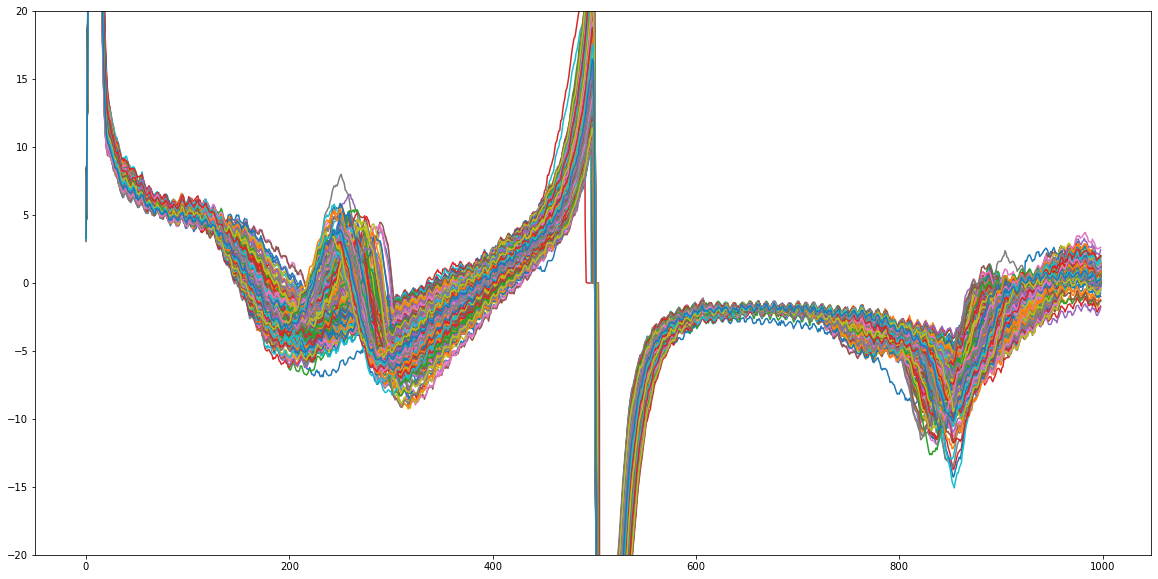

In [19]:
ul, ulidx = np.unique(hold_y_arr, return_index=True, axis=0)

fig, axs = plt.subplots()
fig.set_size_inches(20,10)

for idx in ulidx:
    axs.plot(hold_x_arr[idx,:])
axs.set_ylim(-20,20)

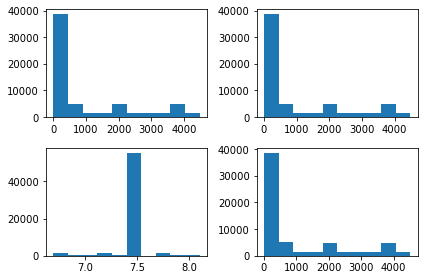

In [20]:
plot_concentrations(hold_y_arr)

In [21]:
hold_conc_pred = predict_non_prob(lab_bijector, vae, hold_data)

10
10
10
10


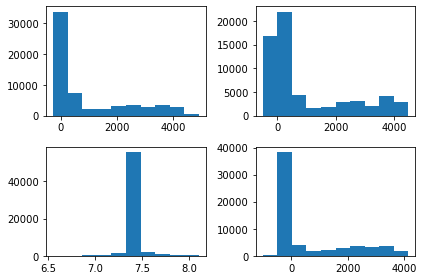

In [22]:
plot_concentrations(hold_conc_pred)

In [23]:
# print('----------------------------------------------------\n\n')
# print('Test Results: ')
# print('RMSE:')
# print_metric(rmse, names, test_y_arr, conc_pred)
# print('R2 Score:')
# print_metric(r2_score, names, test_y_arr, conc_pred)
print('----------------------------------------------------\n\n')
print('Holdout Results: ')
print('RMSE:')
print_metric(rmse, names, hold_y_arr, hold_conc_pred)
print('R2 Score:')
print_metric(r2_score, names, hold_y_arr, hold_conc_pred)
print('----------------------------------------------------\n\n')

# ----------------------------------------------------
# Holdout Results: 
# RMSE:
# DA: 353.5242614746094
# 5HT: 236.11410522460938
# pH: 0.08497358113527298
# NE: 455.54150390625
# R2 Score:
# DA: 0.9321831072225272
# 5HT: 0.9697532673082169
# pH: 0.6272074806440443
# NE: 0.8874826787258907
# ----------------------------------------------------


# Validation Results: 
# RMSE:
# DA: 597.5407104492188
# 5HT: 264.5990295410156
# pH: 0.08884887397289276
# NE: 473.3499450683594
# R2 Score:
# DA: 0.8064105187021449
# 5HT: 0.9620229399535662
# pH: 0.5924154300191126
# NE: 0.8785643254997075
# ----------------------------------------------------

# dropout .8, 1000 epochs
# Holdout Results: 
# RMSE:
# DA: 381.420166015625
# 5HT: 527.9290771484375
# pH: 0.06234191730618477
# NE: 437.3533630371094
# R2 Score:
# DA: 0.9211229248684787
# 5HT: 0.8488202086130727
# pH: 0.7993339927940516
# NE: 0.8963309835252766
# ----------------------------------------------------

# Holdout Results: 
# RMSE:
# DA: 328.60009765625
# 5HT: 222.7253875732422
# pH: 0.07421305775642395
# NE: 451.2471008300781
# R2 Score:
# DA: 0.9414564676317353
# 5HT: 0.9730915512198245
# pH: 0.7156313500325053
# NE: 0.8896402558562272
# ----------------------------------------------------

# Holdout Results: 
# RMSE:
# DA: 228.89488006843868
# 5HT: 159.28784949678047
# pH: 0.06615879457003582
# NE: 608.8871904838503
# R2 Score:
# DA: 0.9715707969368755
# 5HT: 0.9862343635691533
# pH: 0.773862756812846
# NE: 0.79898298650915





----------------------------------------------------


Holdout Results: 
RMSE:
DA: 353.5242614746094
5HT: 236.11410522460938
pH: 0.08497358113527298
NE: 455.54150390625
R2 Score:
DA: 0.9321831072225272
5HT: 0.9697532673082169
pH: 0.6272074806440443
NE: 0.8874826787258907
----------------------------------------------------




In [24]:
# print('Saving predictions for hold out...')

# if not (os.path.exists(out_prefix)):
#     os.makedirs(out_prefix, exist_ok=True)
# np.savetxt(
#     os.path.join(out_prefix, f'{speed}_{hold_probe}_outprobe_ytest.csv'),
#     hold_y_arr, delimiter=',')
# np.savetxt(
#     os.path.join(out_prefix, f'{speed}_{hold_probe}_outprobe_ypred.csv'),
#     hold_conc_pred, delimiter=',')
# # np.savetxt(
# #     os.path.join(out_prefix, f'{speed}_{hold_probe}_outprobe_ypred_05.csv'),
# #     hold_conc_05, delimiter=',')
# # np.savetxt(
# #     os.path.join(out_prefix, f'{speed}_{hold_probe}_outprobe_ypred_95.csv'),
# #     hold_conc_95, delimiter=',')

# print('done.')

In [25]:
val_x_arr, val_y_arr = ds_to_array(lab_bijector, val_data)

val_conc_pred = predict_non_prob(lab_bijector, vae, val_data)

10
10
10
10


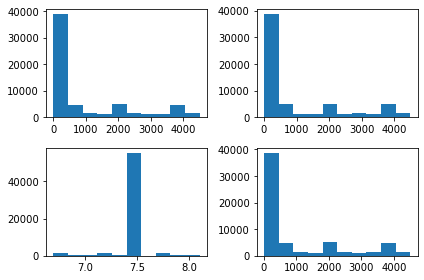

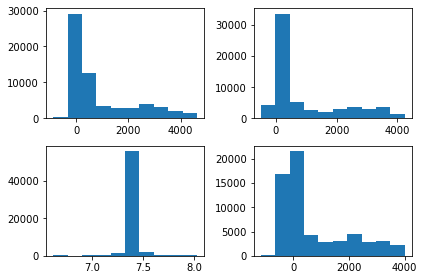

In [26]:
plot_concentrations(val_y_arr)
plot_concentrations(val_conc_pred)

In [27]:


print('----------------------------------------------------\n\n')
print('Validation Results: ')
print('RMSE:')
print_metric(rmse, names, val_y_arr, val_conc_pred)
print('R2 Score:')
print_metric(r2_score, names, val_y_arr, val_conc_pred)
print('----------------------------------------------------\n\n')


----------------------------------------------------


Validation Results: 
RMSE:
DA: 367.68609619140625
5HT: 300.8308410644531
pH: 0.08805300295352936
NE: 489.2878723144531
R2 Score:
DA: 0.9267021994991452
5HT: 0.9509105504055534
pH: 0.5996846245496753
NE: 0.870247002963068
----------------------------------------------------




In [28]:

# Validation Results: 
# RMSE:
# DA: 276.2057189941406
# 5HT: 235.17147827148438
# pH: 0.060689620673656464
# NE: 329.8268737792969
# R2 Score:
# DA: 0.9586037289435875
# 5HT: 0.9699943467196164
# pH: 0.8098400536200738
# NE: 0.9410155599970595
# ----------------------------------------------------

# print('Saving predictions for validation...')

# # np.savetxt(os.path.join(out_prefix,
# #                         f'{speed}_{hold_probe}_inprobe_ytest.csv'),
# #            test_y_arr)
# # np.savetxt(os.path.join(out_prefix,
# #                         f'{speed}_{hold_probe}_inprobe_ypred.csv'),
# #            conc_pred)
# # np.savetxt(
# #     os.path.join(out_prefix, f'{speed}_{hold_probe}_inprobe_ypred_05.csv'),
# #     conc_05)
# # np.savetxt(
# #     os.path.join(out_prefix, f'{speed}_{hold_probe}_inprobe_ypred_95.csv'),
# #     conc_95)
# np.savetxt(os.path.join(out_prefix, f'{speed}_{hold_probe}_yval.csv'),
#            val_y_arr, delimiter=',')
# np.savetxt(os.path.join(out_prefix, f'{speed}_{hold_probe}_yval_pred.csv'),
#            val_conc_pred, delimiter=',')
# np.savetxt(os.path.join(out_prefix, f'{speed}_{hold_probe}_yval_pred_05.csv'),
#            val_conc_05, delimiter=',')
# np.savetxt(os.path.join(out_prefix, f'{speed}_{hold_probe}_yval_pred_95.csv'),
#            val_conc_95, delimiter=',')
# # if not (os.path.exists('./pred_csvs/four_analyte/')):
# #     os.makedirs('./pred_csvs/four_analyte/', exist_ok=True)
# # np.savetxt(f'pred_csvs/four_analyte/holdout/ytest_{speed}_{hold_probe}.csv',
# #            test_y_arr)
# # np.savetxt(f'pred_csvs/four_analyte/holdout/ypred_{speed}_{hold_probe}.csv',
# #            conc_pred)
# # np.savetxt(f'pred_csvs/four_analyte/holdout/yval_{speed}_{hold_probe}.csv',
# #            val_y_arr)
# # np.savetxt(
# #     f'pred_csvs/four_analyte/holdout/yval_pred_{speed}_{hold_probe}.csv',
# #     val_conc_pred)

# print('Predictions Saved.')

In [29]:
# train_x_arr, train_y_arr = ds_to_array(lab_bijector, train_data)


In [30]:
# train_x_arr.shape[0]/20

compare to probabilitic predictions

In [31]:

# # hold_y_arr = np.loadtxt(f'/home/leonardo.barbosa/projects/voltametry/results/four_analyte/good_probe_holdout/pred_csvs/allin/{speed}_{hold_probe}_outprobe_ytest.csv',
# #     delimiter=',')
# # hold_conc_pred = np.loadtxt(f'/home/leonardo.barbosa/projects/voltametry/results/four_analyte/good_probe_holdout/pred_csvs/allin/{speed}_{hold_probe}_outprobe_ypred.csv',
# #     delimiter=',')

# hold_y_arr = np.loadtxt(f'/home/leonardo.barbosa/projects/voltametry/results/four_analyte/good_probe_holdout/pred_csvs/allin/non_prob/slow_CF025_1_outprobe_ytest.csv',
#     delimiter=',')
# hold_conc_pred = np.loadtxt(f'/home/leonardo.barbosa/projects/voltametry/results/four_analyte/good_probe_holdout/pred_csvs/allin/non_prob/slow_CF025_1_outprobe_ypred.csv',
#     delimiter=',')


# print('-------------------- Identity ----------------------\n\n')
# print('Holdout Results: ')
# print('RMSE:')
# print_metric(rmse, names, hold_y_arr, hold_conc_pred)
# print('R2 Score:')
# print_metric(r2_score, names, hold_y_arr, hold_conc_pred)
# print('----------------------------------------------------\n\n')


In [32]:

# hold_y_arr = np.loadtxt(f'/home/leonardo.barbosa/projects/voltametry/results/four_analyte/good_probe_holdout/pred_csvs/allin/non_prob/slow_CF025_outprobe_ytest.csv',
#     delimiter=',')
# hold_conc_pred = np.loadtxt(f'/home/leonardo.barbosa/projects/voltametry/results/four_analyte/good_probe_holdout/pred_csvs/allin/non_prob/slow_CF025_outprobe_ypred.csv',
#     delimiter=',')

# print('-------------------- Original ----------------------\n\n')
# print('Holdout Results: ')
# print('RMSE:')
# print_metric(rmse, names, hold_y_arr, hold_conc_pred)
# print('R2 Score:')
# print_metric(r2_score, names, hold_y_arr, hold_conc_pred)
# print('----------------------------------------------------\n\n')


In [33]:

# hold_y_arr = np.loadtxt(f'/home/leonardo.barbosa/projects/voltametry/results/four_analyte/good_probe_holdout/pred_csvs/allin/non_prob/slow_CF025_5_Adadelta_outprobe_ytest.csv',
#     delimiter=',')
# hold_conc_pred = np.loadtxt(f'/home/leonardo.barbosa/projects/voltametry/results/four_analyte/good_probe_holdout/pred_csvs/allin/non_prob/slow_CF025_5_Adadelta_outprobe_ypred.csv',
#     delimiter=',')

# print('------------------ shifted z-values -----------------\n\n')
# print('Holdout Results: ')
# print('RMSE:')
# print_metric(rmse, names, hold_y_arr, hold_conc_pred)
# print('R2 Score:')
# print_metric(r2_score, names, hold_y_arr, hold_conc_pred)
# print('----------------------------------------------------\n\n')
